# VDP Usage Examples

#### Version 2.0.1

Last updated: 05/16/2018

### Complete Run-Through

I'll demo a complete run-through using two VLITE images of the same field, Mrk110, observed a day apart. Results will be stored in a new database called *example*.

In [1]:
cf = '/home/erichards/work/vdp/example/ex1_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # associate sources with previous detections?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test
  year: 2018
  month: 01
  day: [14, 15]               # list of days to process; [] = all
  image directory:       

In [2]:
%run ../vdp.py ../example/ex1_config.yaml


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################



Create new database example? yes


Connected to new database example.
Dropping tables if they exist...
Creating new tables...
Adding radio catalogs to "radcat" schema...
Adding sources from gpsr5
 -- reading/inserting gpsr5 sources into database
Adding sources from nrl_nvss
 -- reading/inserting nrl_nvss sources into database
Adding sources from gpsr1
 -- reading/inserting gpsr1 sources into database
Adding sources from gleam
 -- reading/inserting gleam sources into database
Adding sources from vlssr
 -- reading/inserting vlssr sources into database
Adding sources from nvss
 -- reading/inserting nvss sources into database
Adding sources from sumss
 -- reading/inserting sumss sources into database
Adding sources from wenss
 -- reading/inserting wenss sources into database
Adding sources from sevenc
 -- reading/inserting sevenc sources into database
Adding sources from tgss
 -- reading/inserting tgss sources into database
Adding sources from lotss
 -- reading/inserting lotss sources into database
Adding sources from lazio

--> Wrote ds9 region file '/home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.pybdsm.srl.reg'


 -- 127/140 sources are inside the circular FOV with radius 2.0 degree(s)
Performing source count quality checks...
...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 0 sources from assoc_source table within 2.0 degrees.
 -- number of matches: 0
 -- number of new sources to add: 127
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['cosmos', 'first', 'gpsr1', 'gpsr5', 'lazio04', 'lofar_hba', 'lotss', 'm31_glg04', 'nordgc', 'tgss']
Attempting to match 127 sources from this image to the cosmos sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 0
Attempting to match 127 sources from this image to the first sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 117
A

--> Wrote ds9 region file '/home/erichards/work/data/test/2018-01/15/Images/10GHz.Mrk110.IPln1.pybdsm.srl.reg'


 -- 129/140 sources are inside the circular FOV with radius 2.0 degree(s)
Performing source count quality checks...
...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 127 sources from assoc_source table within 2.0 degrees.
Limiting to sources in resolution class A (0.0" < BMIN <= 15.0")
 -- 127 sources remaining
Attempting to match 129 sources from this image to 127 sources previously detected in VLITE images...
 -- number of matches: 98
 -- number of new sources to add: 31
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['cosmos', 'first', 'gpsr1', 'gpsr5', 'lazio04', 'lofar_hba', 'lotss', 'm31_glg04', 'nordgc', 'tgss']
Attempting to match 31 sources from this image to the cosmos sky catalog...
 -- found previous matching results

In [3]:
import psycopg2
import psycopg2.extras
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
conn = psycopg2.connect(host='localhost', database='example', user='erichards')
cur = conn.cursor()

You can query the database a couple of different ways to get the number of VLITE unique (VU) sources detected in these images:

In [5]:
cur.execute('SELECT SUM(ndetect) FROM assoc_source WHERE nmatches = 0')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM vlite_unique WHERE detected')
print cur.fetchone()[0]

19
19


You can use the ds9 region files from PyBDSF to follow-up the VU sources. The regions are labeled with the 'src_id' number, which can be extracted from the database **detected_source** table after linking to the 'assoc_id' column in the **vlite_unique** table:

In [6]:
cur.execute('''SELECT src_id, image_id, assoc_id FROM detected_source WHERE assoc_id IN (
        SELECT assoc_id FROM vlite_unique WHERE detected)''')
vurows = cur.fetchall()
vucols = [desc[0] for desc in cur.description]
vudf = pd.DataFrame(vurows, columns=vucols)
vudf

,src_id,image_id,assoc_id
0,8,1,7
1,34,1,30
2,46,1,42
3,50,1,46
4,55,1,51
5,86,1,82
6,127,1,120
7,136,1,126
8,26,2,130
9,50,2,136


##### Advanced
Add flux info by joining to **corrected_flux** table

In [7]:
cur.execute('''SELECT ds.src_id, ds.image_id, ds.assoc_id, ds.ra, ds.dec, ds.maj, ds.min, ds.pa,
        cf.total_flux, cf.snr, cf.distance_from_center FROM detected_source AS ds JOIN
        corrected_flux AS cf ON (ds.src_id, ds.image_id) = (cf.src_id, cf.image_id) WHERE
        ds.assoc_id IN (SELECT assoc_id FROM vlite_unique WHERE detected)''')
vurows = cur.fetchall()
vucols = [desc[0] for desc in cur.description]
vudf = pd.DataFrame(vurows, columns=vucols)
vudf

,src_id,image_id,assoc_id,ra,dec,maj,min,pa,total_flux,snr,distance_from_center
0,8,1,7,144.229622,53.151793,20.543590,13.264106,55.467239,87.698093,5.33675,1.972220
1,34,1,30,142.473162,52.032446,26.144142,13.449949,11.291133,50.027889,6.19292,0.761055
2,46,1,42,142.223770,53.872549,17.348642,10.622192,32.278157,38.698423,4.38213,1.679810
3,50,1,46,142.134525,51.723271,18.519580,12.887817,45.405682,24.270708,5.12949,0.760649
4,55,1,51,142.048175,51.879544,18.007637,14.996263,170.329578,22.739983,4.93363,0.612184
5,86,1,82,140.844620,53.067259,17.852701,13.527317,46.090318,36.577716,5.08359,0.829099
6,127,1,120,139.200677,52.642539,23.894711,16.937064,61.871692,79.566358,5.72935,1.329770
7,136,1,126,138.308774,52.156556,37.900624,16.625898,166.017768,246.132052,7.08907,1.839100
8,26,2,130,142.995414,51.468651,31.089014,17.891878,76.558708,82.371950,5.94007,1.326340
9,50,2,136,142.105729,53.276082,41.306995,17.506098,59.713738,765.903746,42.46080,1.102330


Since these two images cover the same field-of-view, every detected VU source should have a counterpart in the other image, detected or not. VU sources that were detected in both images are of particular interest:

In [8]:
cur.execute('SELECT * FROM assoc_source WHERE ndetect > 1 AND nmatches = 0')
print cur.fetchall()

[(120, 139.200669443101, 0.000472338828173761, 52.6426889951381, 0.000352486124005548, 'A', 2, 0)]


This source (s127 in image 1) is displayed below with the FIRST (orange) and TGSS (cyan) regions overlaid. It's obvious that s127 is not really a VU source, even though it wasn't matched to any of the FIRST sources or the blended TGSS source. This is a good example of a case where you might want to manually add a catalog matching result for this source just to indicate that it is not a true VU source.

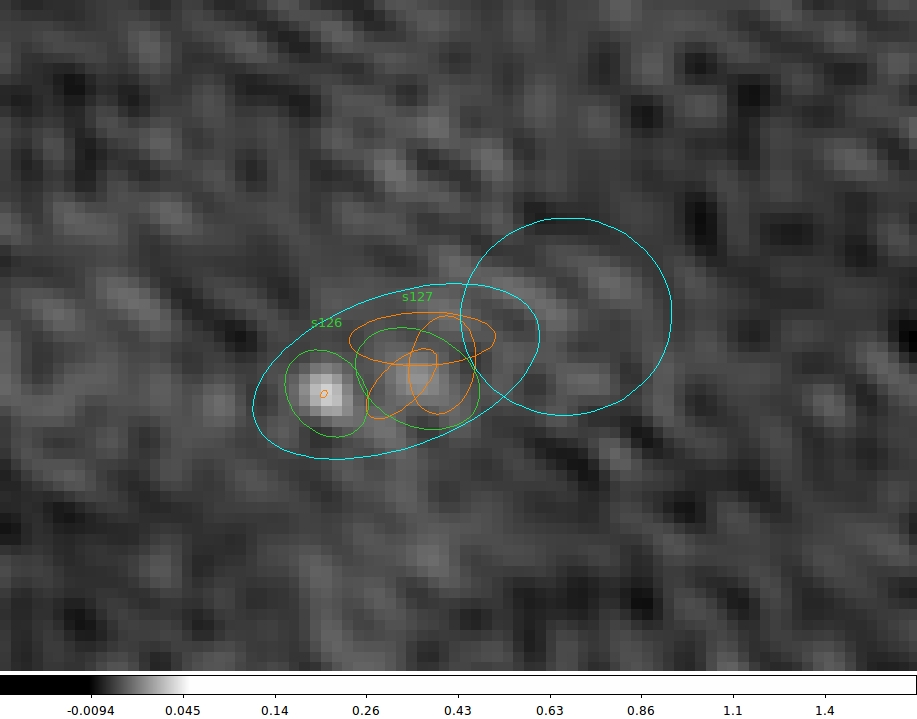

In [9]:
from IPython.display import Image
Image(filename='../../data/test/2018-01/14/missed_catalog_match.jpeg')

In [10]:
cur.close()
conn.close()

#### Manually Adding Missed Catalog Matches

Use the optional command line argument ``--manually_add_match`` to update the catalog matching results for any source in the **assoc_source** table. You just need to provide the **assoc_source** table id, the name of the catalog, and, optionally, the id of the catalog source. Although it's not required, you can get the id and angular distance of the closest catalog source by running this image through source finding and catalog matching to FIRST.

In [11]:
cf = '/home/erichards/work/vdp/example/ex2_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: no      # associate sources with previous detections?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: no        # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: yes              # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test
  year: 2018
  month: 01
  day: [14]                   # list of days to process; [] = all
  image directory:       

In [12]:
%run ../vdp.py ../example/ex2_config.yaml


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.
__________________________________________________________________________________
Starting /home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Initializing image.
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 140 sources in 17.76 seconds


--> Wrote ds9 region file '/home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.pybdsm.srl.reg'


 -- 127/140 sources are inside the circular FOV with radius 2.0 degree(s)
Performing source count quality checks...
...image passed.
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['first']
Attempting to match 127 sources from this image to the first sky catalog...
--------------------------------------------------------------
VLITE_src_id match catalog_src_id separation (arcsec)
--------------------------------------------------------------
0		True	80877	3.19807867923
2		True	82219	2.03702992702
3		True	74571	4.3805003867
5		True	78006	2.4620065987
6		True	85110	2.0315087728
7		True	81712	1.77456439091
8		False	71935	6.1507453711
9		True	69208	1.93395198522
10		True	69228	0.877967504566
12		True	77203	1.80364569943
13		True	78855	0.536662499703
14		True	87310	2.54351455565
15		True	87214	2.51059664002
16		True	71657	0.733285386781
17		True	79112	1.71263282774
18		True	87770	0.792888

Source 127 (associated id 120) is just over the threshold for being matched to the FIRST source 76065.

The matching results for VLITE associated source 120 can now be manually inserted into the database:

120, FIRST, 76065, 6.1825980702

In [13]:
%run ../vdp.py ../example/ex2_config.yaml --manually_add_match


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.



Please enter the source assoc_source id, the name of the catalog, and, optionally, the id of the matched catalog source and the angular separation in arcseconds, in that order one per line. Hit "q" when you are done. You may alternatively provide a similarly formatted text file with one catalog match per line:
120, FIRST, 76065, 6.1825980702
q


Adding new catalog matching results for assoc_ids [120]...


In [14]:
conn = psycopg2.connect(host='localhost', database='example', user='erichards')
cur = conn.cursor()

In [15]:
cur.execute('SELECT * FROM assoc_source WHERE id = 120')
print cur.fetchone()

(120, 139.200669443101, 0.000472338828173761, 52.6426889951381, 0.000352486124005548, 'A', 2, 1)


In [16]:
cur.execute('SELECT * FROM catalog_match WHERE assoc_id = 120')
cols = [desc[0] for desc in cur.description]
print cols
print cur.fetchone()

['id', 'catalog_id', 'src_id', 'assoc_id', 'separation']
(247, 2, 76065, 120, 6.1826)


In [17]:
cur.execute('SELECT * FROM vlite_unique WHERE assoc_id = 120')
print cur.fetchone()

None


In [18]:
cur.close()
conn.close()

The source no longer has any entries in the **vlite_unique** table, its 'nmatches' in the **assoc_source** table is updated, and a new entry is added to the **catalog_match** table. If the 'catalog_id' and 'separation' columns aren't provided, they are filled with -1 to reflect that these columns haven't been specified.

### Single Image Test Run

You can test run an image (or images) without committing any results to the database by setting the *save to database* option in the configuration file to "no" or ``False``. Sources will be extracted like normal & a ds9 region file will still be created. The detected sources will be associated with sources in the **assoc_source** table and the association results will be printed to the terminal instead of being recorded in the database. All new detected sources with no association will be cross-matched with every catalog specified in the configuration file, regardless of resolution. Those results will also be printed to the terminal. The positional cross-matching is significantly slower in this mode since it is happening outside the database, so it is recommended that you only specify a few catalogs. Remember that an empty list will default to using all available catalogs.

In [20]:
# Add the 2018-14 image first
%run ../vdp.py ../example/ex3_config.yaml --quiet


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.
______________________________________________________________________________________
Starting /home/erichards/work/data/test/2018-01/14/Images/10GHz.J0920+4441.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Adding new entry to image table.
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 72 sources in 16.85 seconds


--> Wrote ds9 region file '/home/erichards/work/data/test/2018-01/14/Images/10GHz.J0920+4441.IPln1.pybdsm.srl.reg'


 -- 69/72 sources are inside the circular FOV with radius 2.0 degree(s)
Performing source count quality checks...
...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 0 sources from assoc_source table within 2.0 degrees.
 -- number of matches: 0
 -- number of new sources to add: 69
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['cosmos', 'first', 'gpsr1', 'gpsr5', 'lazio04', 'lofar_hba', 'lotss', 'm31_glg04', 'nordgc', 'tgss']
Attempting to match 69 sources from this image to the cosmos sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 0
Attempting to match 69 sources from this image to the first sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 63
Attempt

In [21]:
cf = '/home/erichards/work/vdp/example/ex4_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # associate sources with previous detections?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: no        # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test
  year: 2018
  month: 01
  day: [15]                   # list of days to process; [] = all
  image directory:       

In [22]:
%run ../vdp.py ../example/ex4_config.yaml


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.
______________________________________________________________________________________
Starting /home/erichards/work/data/test/2018-01/15/Images/10GHz.J0920+4441.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Initializing image.
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 95 sources in 18.61 seconds


--> Wrote ds9 region file '/home/erichards/work/data/test/2018-01/15/Images/10GHz.J0920+4441.IPln1.pybdsm.srl.reg'


 -- 90/95 sources are inside the circular FOV with radius 2.0 degree(s)
Performing source count quality checks...
...image passed.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 69 sources from assoc_source table within 2.0 degrees.
Limiting to sources in resolution class A (0.0" < BMIN <= 15.0")
 -- 69 sources remaining
Attempting to match 90 sources from this image to 69 sources previously detected in VLITE images...
-------------------------------------------------------------------------------------------------------------------------------
src_id match assoc_id	ra		e_ra			dec		e_dec		separation (arcsec)	ndetect
-------------------------------------------------------------------------------------------------------------------------------
0	True	159	142.933000872	7.71761509242e-05	44.5330340034	6.15522197663e-05	2.75382898378	2
1	True	160	142.788337378	0.00021676045503	44.4775423715	0.000162212268614	2.15807073057	2
2	True	161	142.73760

### Reprocess an Image

Let's say I want to re-do the first image with different PyBDSF parameters. This can be accomplished by setting *reprocess* in the configuration file to "yes" or ``True``. **vdp** will delete all previously detected sources in the **detected_source** table for the images specified in the configuration file which will propagate through to all other affected tables. Keep in mind that even if the source finding results are the same, the association results will likely be slightly different since the order in which the weighted average positions are calculated has changed.

In this example, I'll turn off the adaptive_rms_box setting in PyBDSF and force rms_box = (100, 30):

In [23]:
cf = '/home/erichards/work/vdp/example/ex5_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # associate sources with previous detections?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: yes              # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test
  year: 2018
  month: 01
  day: [14]                   # list of days to process; [] = all
  image directory:       

In [24]:
%run ../vdp.py ../example/ex5_config.yaml


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.
__________________________________________________________________________________
Starting /home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Updating existing entries in image table.
Removing previous sources...
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 131 sources in 13.78 seconds


--> Wrote ds9 region file '/home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.pybdsm.srl.reg'


 -- 121/131 sources are inside the circular FOV with radius 2.0 degree(s)
Performing source count quality checks...
...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 129 sources from assoc_source table within 2.0 degrees.
Limiting to sources in resolution class A (0.0" < BMIN <= 15.0")
 -- 129 sources remaining
Attempting to match 121 sources from this image to 129 sources previously detected in VLITE images...
 -- number of matches: 97
 -- number of new sources to add: 24
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['cosmos', 'first', 'gpsr1', 'gpsr5', 'lazio04', 'lofar_hba', 'lotss', 'm31_glg04', 'nordgc', 'tgss']
Attempting to match 24 sources from this image to the cosmos sky catalog...
 -- found previous matching results

In [25]:
conn = psycopg2.connect(host='localhost', database='example', user='erichards')
cur = conn.cursor()

In [26]:
cur.execute('''SELECT SUM(ndetect) FROM assoc_source WHERE nmatches = 0 AND id IN (
        SELECT assoc_id FROM detected_source WHERE image_id IN (1, 2))''')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM vlite_unique WHERE detected AND image_id IN (1, 2)')
print cur.fetchone()[0]

16
16


In [27]:
cur.close()
conn.close()

There were 9 fewer sources found in the image with the adjusted PyBDSF parameters and 1 less VU source than before (after manually adding the catalog matching results for one).

### Remove Bad Images

If you want to remove a bad image or images from the database completely, use the ``--remove_image`` command line option:

In [28]:
%run ../vdp.py ../example/ex5_config.yaml --remove_image


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.



Please enter the image(s) filename(s) starting at least with the year-month directory (i.e. 2018-01/15/Images/10GHz.Mrk110.IPln1.fits), or provide a text file with one filename per line:
/home/erichards/work/data/test/2018-01/14/Images/10GHz.J0920+4441.IPln1.fits


Preparing to remove image(s) ['2018-01/14/Images/10GHz.J0920+4441.IPln1.fits'] from the database.



Are you sure? yes


Deleting image(s) from the database...


### Update Catalog Matching Results

There are a few different ways to update the catalog matching results. You can delete and re-do all matching results, remove results for select catalogs only, and update matching results for sources by adding new catalogs.

#### Redo All

Turn on by setting the *catalog_matching* stage to "yes" or ``True`` and the *redo match* option to "yes" or ``True``.

This option begins by deleting all catalog matching results for every source associated with sources detected in the images provided in the configuration file. Catalog matching is then re-run like normal on all the images' associated sources. Since this operates on sources in the **assoc_source** table, keep in mind that this could also affect results for sources detected in other images that you haven't specified but which are associated with the same sources.

In [29]:
cf = '/home/erichards/work/vdp/example/ex6_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: no          # extract sources from image?
  source association: no      # associate sources with previous detections?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: yes             # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test
  year: 2018
  month: 01
  day: [14, 15]               # list of days to process; [] = all
  image directory:       

In [30]:
%run ../vdp.py ../example/ex6_config.yaml


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.
__________________________________________________________________________________
Starting /home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Initializing image.
Removing previous sky catalog matching results for 121 sources.
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['cosmos', 'first', 'gpsr1', 'gpsr5', 'lazio04', 'lofar_hba', 'lotss', 'm31_glg04', 'nordgc', 'tgss']
Attempting to match 121 sources from this image to the cosmos sky catalog...
 -- found previous matching 

In [31]:
conn = psycopg2.connect(host='localhost', database='example', user='erichards')
cur = conn.cursor()

In [32]:
cur.execute('SELECT SUM(ndetect) FROM assoc_source WHERE nmatches = 0')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM vlite_unique WHERE detected')
print cur.fetchone()[0]

16
16


In [33]:
cur.execute('SELECT * FROM assoc_source WHERE id = 120')
cols = [desc[0] for desc in cur.description]
print cols
print cur.fetchone()

['id', 'ra', 'e_ra', 'dec', 'e_dec', 'res_class', 'ndetect', 'nmatches']
(120, 139.200685906995, 0.000465927898033572, 52.6426738296795, 0.000350344665139218, 'A', 2, 1)


In [34]:
cur.execute('SELECT * FROM catalog_match WHERE assoc_id = 120')
cols = [desc[0] for desc in cur.description]
print cols
print cur.fetchone()

['id', 'catalog_id', 'src_id', 'assoc_id', 'separation']
(711, 2, 76065, 120, 6.31306)


In [35]:
cur.close()
conn.close()

The previous VU source which had 2 detections but no catalog matches was successfully matched to a FIRST source this time around. This is because the separation between it and the closest FIRST source is actually within the matching limit for image 2's beam semi-minor axis size, but not for image 1. In its standard operating mode, the pipeline will see that source 121 in the **assoc_source** table has already been matched to all the relevant catalogs and will not waste time re-doing matching for image 2. When re-doing all the matching results, though, *every* source in the **assoc_source** table that belongs to the current image is re-matched, regardless of any previous results.

#### Remove Matching Results for Select Catalogs

In the event that a survey or catalog that has been used for cross-matching in the database has been updated, you'll need to remove the existing results and re-match the sources. You can accomplish this by either re-doing the cross-matching for *all* catalogs using the *redo match* option demonstrated above, or remove results only for the catalog in question. Just use the ``--remove_catalog_matches`` command line option and provide the name of the catalog(s).

In [36]:
%run ../vdp.py ../example/ex6_config.yaml --remove_catalog_matches


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.



For which catalogs would you like to remove matching results? (List catalogs separated by a comma.)
tgss


Removing matching results for tgss...


#### Update Matching Results with New Catalog

You can now re-do the cross-matching with the catalog that was removed using the *update match* configuration file option. This option can also be used to add results for a new catalog.

In [37]:
cf = '/home/erichards/work/vdp/example/ex7_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: no          # extract sources from image?
  source association: no      # associate sources with previous detections?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: yes           # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test
  year: 2018
  month: 01
  day: [14, 15]               # list of days to process; [] = all
  image directory:       

In [38]:
%run ../vdp.py ../example/ex7_config.yaml


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.
__________________________________________________________________________________
Starting /home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Initializing image.
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['tgss']
Attempting to match 121 sources from this image to the tgss sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 92
Completed sky catalog cross-matching for image
/home/erichards/work/data/test/2018-01/14/Images/10GHz.Mrk110.IP

### Remove Fake Sources

After following-up the VU sources, you may want to remove the ones determined to be imaging artifacts. You can do this using the ``remove_source`` command line option. Sources are removed from the **assoc_source**, **catalog_match**, and **vlite_unique** tables, but not the **detected_source** table. The corresponding entries in that table are given an 'assoc_id' value of -1.

The command line option will prompt you for the assoc_id values of the sources you wish to remove. You can type them in by-hand as a comma separated list if there are only a few. For bulk removal, it will be easier to provide a text file with each assoc_id on a separate line. In this example, I'll remove every source with 'nmatches' = 0 by writing their assoc_ids to a text file.

In [39]:
conn = psycopg2.connect(host='localhost', database='example', user='erichards')
cur = conn.cursor()

In [40]:
# Make a list of source ids to remove
cur.execute('SELECT id FROM assoc_source WHERE nmatches = 0')
rows = cur.fetchall()
assoc_ids = [row[0] for row in rows]

In [41]:
print len(assoc_ids)
print assoc_ids[:5]

16
[130, 136, 138, 140, 141]


In [42]:
with open('../sources_to_remove.txt', 'w') as f:
    for asid in assoc_ids:
        f.write('%i\n' % asid)

In [43]:
%run ../vdp.py ../example/ex7_config.yaml --remove_source


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/201801.log
###################################################
Connected to database example.
Using existing database example.



Please enter the id number(s) (i.e. 1, 2, 3) of the source(s) you wish to remove from the database assoc_source table, or provide a text file with one id number per line:
../sources_to_remove.txt


Removing row(s) [130, 136, 138, 140, 141, 147, 148, 149, 244, 228, 232, 233, 236, 238, 152, 153] from the assoc_source table...


In [44]:
cur.close()
conn.close()